In [46]:
import modin.pandas as pd
from transformers import AutoTokenizer
import json
import ast
from datasets import load_dataset

### External source

In [47]:
external_df = load_dataset("lmsys/chatbot_arena_conversations")["train"].to_json(
    "tmp.json"
)
external_df = pd.read_json("tmp.json", lines=True).sort_values(
    ascending=True, by=["tstamp"]
)

external_df["label"] = external_df["winner"].map(
    {"model_a": 0, "model_b": 1, "tie": 2, "tie (bothbad)": 2}
)

Creating json from Arrow format:   0%|          | 0/33 [00:00<?, ?ba/s]

In [49]:
def make_pairs(row):
    prompt = row.conversation_a[0]["content"]
    response_a = row.conversation_a[1]["content"]
    response_b = row.conversation_b[1]["content"]

    prompt = prompt.encode("utf-8", errors="ignore").decode("utf-8")
    response_a = response_a.encode("utf-8", errors="ignore").decode("utf-8")
    response_b = response_b.encode("utf-8", errors="ignore").decode("utf-8")
    row["response_a"] = response_a
    row["response_b"] = response_b
    row["prompt"] = prompt
    row["left"] = f"<|source|> {prompt}\n\n\n\n <|candidate|> {response_a}"
    row["right"] = f"<|source|> {prompt}\n\n\n\n <|candidate|> {response_b}"
    row["both"] = (
        f"Prompt: {prompt}\n\n\n\n Model A: {response_a} \n\n\n\n  Model B: {response_b}"
    )

    return row

In [51]:
external_df = external_df.apply(make_pairs, axis=1)

In [52]:
external_df

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag,label,response_a,response_b,prompt,left,right,both
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",1,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,What is the difference between OpenCL and CUDA?,<|source|> What is the difference between Open...,<|source|> What is the difference between Open...,Prompt: What is the difference between OpenCL ...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",2,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,Why did my parent not invite me to their wedding?,<|source|> Why did my parent not invite me to ...,<|source|> Why did my parent not invite me to ...,Prompt: Why did my parent not invite me to the...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...",1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",1,Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,"Fuji vs. Nikon, which is better?","<|source|> Fuji vs. Nikon, which is better?\n\...","<|source|> Fuji vs. Nikon, which is better?\n\...","Prompt: Fuji vs. Nikon, which is better?\n\n\n..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",1,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,How to build an arena for chatbots?,<|source|> How to build an arena for chatbots?...,<|source|> How to build an arena for chatbots?...,Prompt: How to build an arena for chatbots?\n\...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",0,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",When is it today?,<|source|> When is it today?\n\n\n\n <|candida...,<|source|> When is it today?\n\n\n\n <|candida...,Prompt: When is it today?\n\n\n\n Model A: I'm...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,8777c4945d85469d96cd26fc2ea6f64a,alpaca-13b,claude-instant-v1,tie,arena_user_21246,[{'content': 'who is the president of the U.S....,[{'content': 'who is the president of the U.S....,1,True,English,1.687774e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",2,Joe Biden is currently the President of the Un...,Joe Biden is currently the 46th president of t...,who is the president of the U.S.A?,<|source|> who is the president of the U.S.A?\...,<|source|> who is the president of the U.S.A?\...,Prompt: who is the president of the U.S.A?\n\n...
32996,86063a921be548989c55b85497ab009a,claude-instant-v1,guanaco-33b,model_a,arena_user_20785,[{'content': 'how

<Axes: xlabel='model_a'>

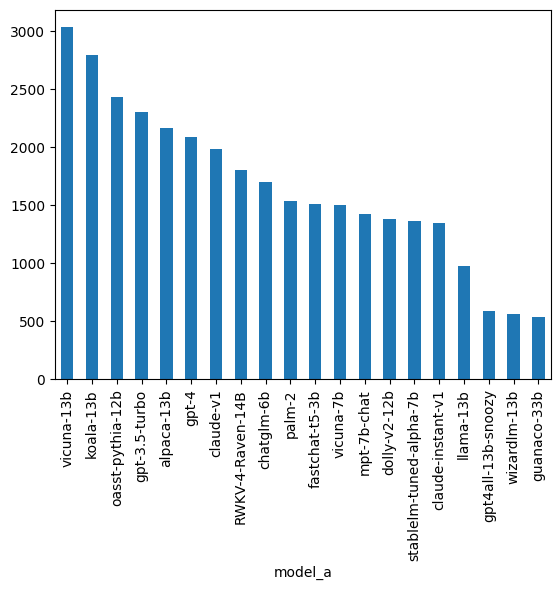

In [53]:
# create wide histogram of model_a vs model_b
external_df.model_a.value_counts().plot(kind="bar")

<Axes: xlabel='model_b'>

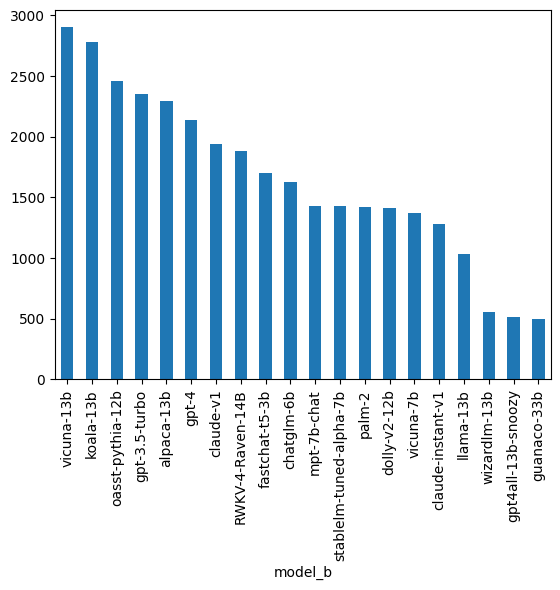

In [7]:
external_df.model_b.value_counts().plot(kind="bar")

### Provided dataframe

In [55]:
df = pd.read_csv("../data/train.csv")
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


In [56]:
import json


def safe_eval(s):
    try:
        return json.loads(s.replace("null", '""'))
    except (ValueError, SyntaxError, json.JSONDecodeError):
        # If parsing fails, return the input itself if it's already a list or return an empty list
        if isinstance(s, list):
            return s
        elif isinstance(s, int):
            return [str(s)]
        else:
            return []


# Convert each element to string before joining
def join_elements(elements):
    return " ".join(map(str, elements))


df["prompt"] = df.prompt.map(lambda x: join_elements(safe_eval(x)))
df["response_a"] = df.response_a.map(
    lambda x: join_elements(safe_eval(x.replace("null", "''")))
)
df["response_b"] = df.response_b.map(
    lambda x: join_elements(safe_eval(x.replace("null", "''")))
)
df["label"] = df.apply(
    lambda row: (
        0 if row["winner_model_a"] == 1 else 1 if row["winner_model_b"] == 1 else 2
    ),
    axis=1,
)

In [57]:
def make_pairs(row):
    row["encode_fail"] = False
    prompt = row.prompt.encode("utf-8", errors="ignore").decode("utf-8")
    response_a = row.response_a.encode("utf-8", errors="ignore").decode("utf-8")
    response_b = row.response_b.encode("utf-8", errors="ignore").decode("utf-8")
    row["both"] = (
        f"Prompt: {prompt}\n\n\n\n Model A: {response_a} \n\n\n\n  Model B: {response_b}"
    )
    row["left"] = f"<|source|> {prompt}\n\n\n\n <|candidate|> {response_a}"
    row["right"] = f"<|source|> {prompt}\n\n\n\n <|candidate|> {response_b}"
    row["response_a"] = response_a
    row["response_b"] = response_b

    return row

In [58]:
df = df.apply(make_pairs, axis=1)

In [59]:
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,label,encode_fail,both,left,right
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,0,False,Prompt: Is it morally right to try to have a c...,<|source|> Is it morally right to try to have ...,<|source|> Is it morally right to try to have ...
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,1,False,Prompt: What is the difference between marriag...,<|source|> What is the difference between marr...,<|source|> What is the difference between marr...
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,2,False,Prompt: explain function calling. how would yo...,<|source|> explain function calling. how would...,<|source|> explain function calling. how would...
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,0,False,Prompt: How can I create a test set for a very...,<|source|> How can I create a test set for a v...,<|source|> How can I create a test set for a v...
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,1,False,Prompt: What is the best way to travel from Te...,<|source|> What is the best way to travel from...,<|source|> What is the best way to travel from...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"A simple mnemonic for π:\n""How I wish I could ...","Sure, let's break it down:\n\n1. ""How"" has 3 l...",Here is how that mnemonic represents the digit...,1,0,0,0,False,"Prompt: A simple mnemonic for π:\n""How I wish ...","<|source|> A simple mnemonic for π:\n""How I wi...","<|source|> A simple mnemonic for π:\n""How I wi..."
57473,4294692063,claude-2.0,llama-2-13b-chat,"In python, implement a naive Bayes with gaussi...",Here is an implementation of a naive Bayes cla...,Sure! Here's an implementation of a naive Baye...,1,0,0,0,False,"Prompt: In python, implement a naive Bayes wit...","<|source|> In python, implement a naive Bayes ...","<|source|> In python, implement a naive Bayes ..."
57474,4294710549,claude-1,alpaca-13b,is it unethical to work on building weapons? a...,Working on weapons technology raises some ethi...,It depends on the context. Weapons can be used...,1,0,0,0,False,Prompt: is it unethical to work on building we...,<|source|> is it unethical to work on building...,<|source|> is it unethical to work on building...
57475,4294899228,palm-2,tulu-2-dpo-70b,"If a bait contains 0,0025% bromadiolon then ho...",Bromadiolone is a rodenticide which is most of...,"As an AI language model, I do not promote or c...",0,1,0,1,False,"Prompt: If a bait contains 0,0025% bromadiolon...","<|source|> If a bait contains 0,0025% bromadio...","<|source|> If a bait contains 0,0025% bromadio..."


<Axes: xlabel='model_a'>

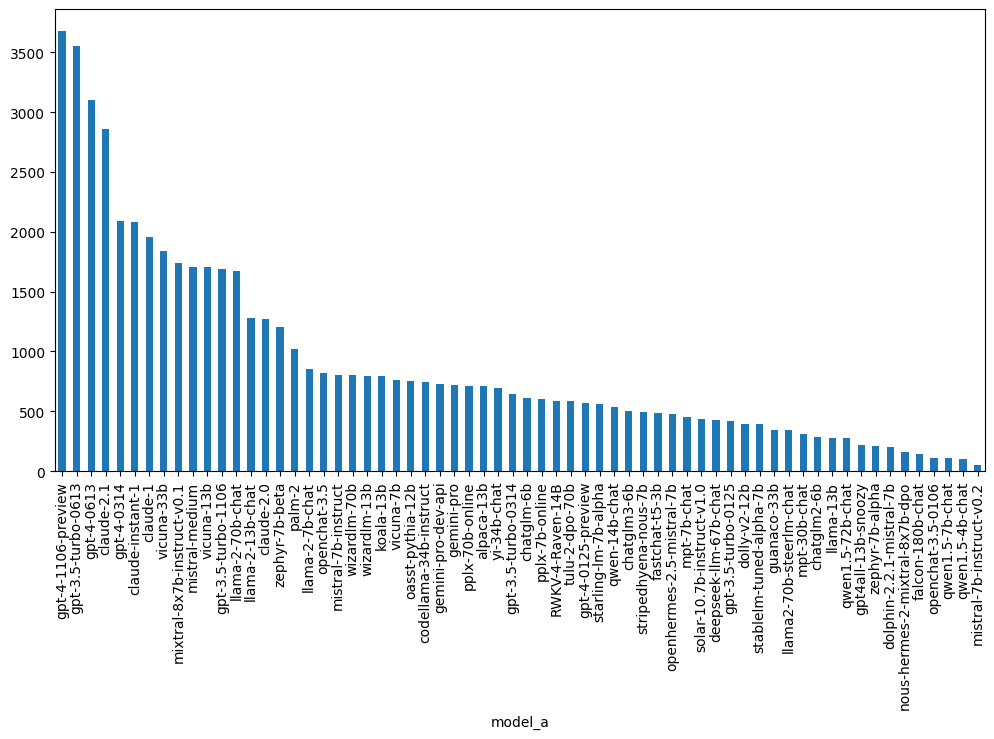

In [60]:
df.model_a.value_counts().plot(kind="bar", figsize=(12, 6))

<Axes: xlabel='model_b'>

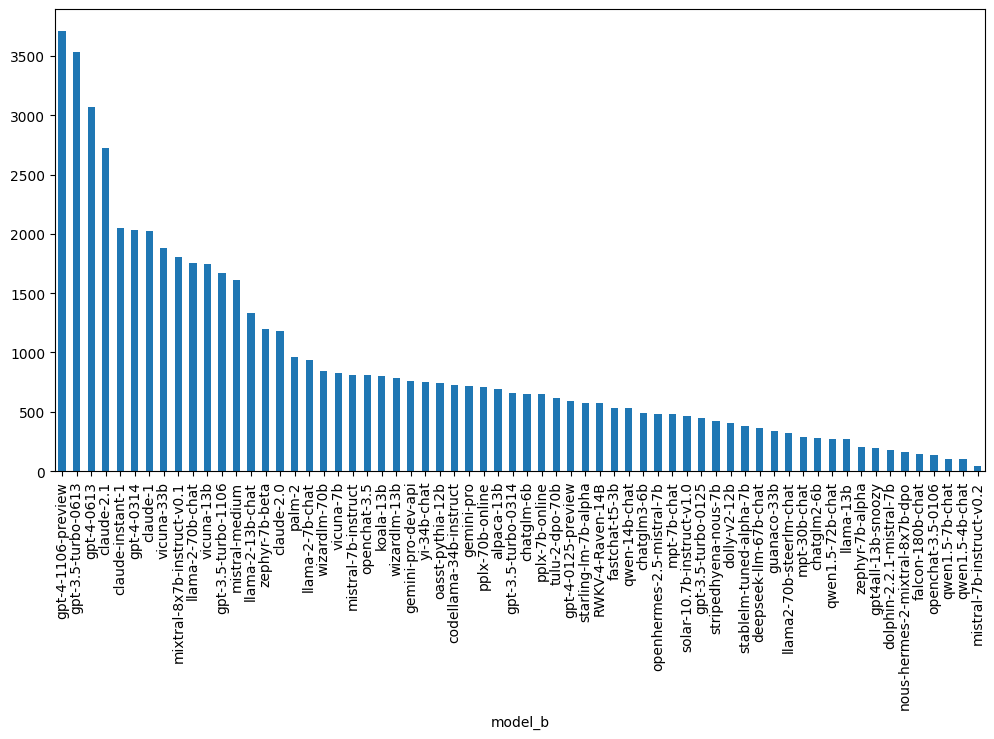

In [15]:
df.model_b.value_counts().plot(kind="bar", figsize=(12, 6))

### Find intersection of two dataframes and drop dublicates in external source

In [61]:
intersection = set(df["prompt"]).intersection(set(external_df["prompt"]))

In [62]:
# to list
intersection = list(intersection)
intersection

['Give me suggestion to figure out my life goals. i am 29 year old man, studying master in cs in USA',
 'test',
 'Give me a research roadmap on how to reach Mars in 30 days.',
 'Based on the given context, correctly answer the query. If the context is insufficient to address the query, state that. Do not make information up.\nContext: Nikhil is my brother. He likes lemons. He enjoys lemonade in hot summers.\nQuery: Who likes citrus fruit?',
 'Write a 3 minute speech on the topic “how relaxing” and make it funny',
 'Write a 10 sentence description of the book, The Alloy of Law, by Brandon Sanderson.',
 '1. use a fork to whisk the eggs\n2. Add butter and herbs\n3.\n4. Flip the omelet\n5. Garnish and serve\nFill in the missing step with single sentence',
 'How is the shader code compiled into GPU instructions?',
 'What is the fastest thing in the universe?',
 'Who is the Queen of England?',
 'translate into wolfram alpha language the equation of a parabola between -1 to 1',
 'How paramete

In [63]:
len(intersection)

6803

In [64]:
# remove from external_df rows that are in the intersection
external_df = external_df[~external_df["prompt"].isin(intersection)]

In [65]:
external_df

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag,label,response_a,response_b,prompt,left,right,both
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",2,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,Why did my parent not invite me to their wedding?,<|source|> Why did my parent not invite me to ...,<|source|> Why did my parent not invite me to ...,Prompt: Why did my parent not invite me to the...
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",1,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,How to build an arena for chatbots?,<|source|> How to build an arena for chatbots?...,<|source|> How to build an arena for chatbots?...,Prompt: How to build an arena for chatbots?\n\...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",0,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",When is it today?,<|source|> When is it today?\n\n\n\n <|candida...,<|source|> When is it today?\n\n\n\n <|candida...,Prompt: When is it today?\n\n\n\n Model A: I'm...
5,c0fc42c6f5f14f2aa5a89f71f8553730,vicuna-13b,koala-13b,model_a,arena_user_973,[{'content': 'Count from 1 to 10 with step = 3...,[{'content': 'Count from 1 to 10 with step = 3...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",0,"1, 4, 7, 10\n\nCounting with a step of 3 means...","1, 4, 7, 10",Count from 1 to 10 with step = 3,<|source|> Count from 1 to 10 with step = 3\n\...,<|source|> Count from 1 to 10 with step = 3\n\...,Prompt: Count from 1 to 10 with step = 3\n\n\n...
6,c4938f25c1d94fc1b110ace95a2243d0,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'Emoji for ""sharing"". List 10', '...","[{'content': 'Emoji for ""sharing"". List 10', '...",1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",0,1. 💪 Sharing progress or achievements\n2. 📝 Sh...,1. Sharing hands\n* Share icon\n* Group ...,"Emoji for ""sharing"". List 10","<|source|> Emoji for ""sharing"". List 10\n\n\n\...","<|source|> Emoji for ""sharing"". List 10\n\n\n\...","Prompt: Emoji for ""sharing"". List 10\n\n\n\n M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32993,23dd48fffe20494c88b6cecb59314f56,claude-instant-v1,gpt4all-13b-snoozy,model_a,arena_user_21279,[{'content': 'Describe a plot for a stoner com...,[{'content': 'Describe a plot for a stoner com...,1,True,English,1.687773e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil...",0,Here is a plot outline for a stoner comedy fil...,"Title: ""Cynthia's High Journey""\n\nPlot:\nCynt...",Describe a plot for a stoner comedy film set i...,<|source|> Describe a plot for a stoner comedy...,<|source|> Describe a plot for a stoner comedy...,Prompt: Describe a plot for a stoner comedy fi...
32994,fb4d58ef8649472783d364a9c1c8239e,palm-2,chatglm-6b,model_a,arena_user_21398,[{'content': 'If a tap is outputting 2500 ml a...,[

In [66]:
columns = ["prompt", "response_a", "response_b", "label", "both", "left", "right"]

In [67]:
external_df[columns].reset_index(drop=True)

,prompt,response_a,response_b,label,both,left,right
0,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,2,Prompt: Why did my parent not invite me to the...,<|source|> Why did my parent not invite me to ...,<|source|> Why did my parent not invite me to ...
1,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,1,Prompt: How to build an arena for chatbots?\n\...,<|source|> How to build an arena for chatbots?...,<|source|> How to build an arena for chatbots?...
2,When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",0,Prompt: When is it today?\n\n\n\n Model A: I'm...,<|source|> When is it today?\n\n\n\n <|candida...,<|source|> When is it today?\n\n\n\n <|candida...
3,Count from 1 to 10 with step = 3,"1, 4, 7, 10\n\nCounting with a step of 3 means...","1, 4, 7, 10",0,Prompt: Count from 1 to 10 with step = 3\n\n\n...,<|source|> Count from 1 to 10 with step = 3\n\...,<|source|> Count from 1 to 10 with step = 3\n\...
4,"Emoji for ""sharing"". List 10",1. 💪 Sharing progress or achievements\n2. 📝 Sh...,1. Sharing hands\n* Share icon\n* Group ...,0,"Prompt: Emoji for ""sharing"". List 10\n\n\n\n M...","<|source|> Emoji for ""sharing"". List 10\n\n\n\...","<|source|> Emoji for ""sharing"". List 10\n\n\n\..."
...,...,...,...,...,...,...,...
22790,Describe a plot for a stoner comedy film set i...,Here is a plot outline for a stoner comedy fil...,"Title: ""Cynthia's High Journey""\n\nPlot:\nCynt...",0,Prompt: Describe a plot for a stoner comedy fi...,<|source|> Describe a plot for a stoner comedy...,<|source|> Describe a plot for a stoner comedy...
22791,If a tap is outputting 2500 ml a minute. How m...,"A litre is equal to 1000 ml, so 50 litres is e...",To find out how long it will take to fill a co...,0,Prompt: If a tap is outputting 2500 ml a minut...,<|source|> If a tap is outputting 2500 ml a mi...,<|source|> If a tap is outputting 2500 ml a mi...
22792,who is the president of the U.S.A?,Joe Biden is currently the President of the Un...,Joe Biden is currently the 46th president of t...,2,Prompt: who is the president of the U.S.A?\n\n...,<|source|> who is the president of the U.S.A?\...,<|source|> who is the president of the U.S.A?\...
22793,how to train lora for stable diffusion? explai...,Training Stable Diffusion models like LoRA req...,Lora is a machine learning model that is used ...,0,Prompt: how to train lora for stable diffusion...,<|source|> how to train lora for stable diffus...,<|source|> how to train lora for stable diffus...


In [69]:
external_df_col = external_df[columns].reset_index(drop=True)
df_col = df[columns].reset_index(drop=True)

In [70]:
print(len(external_df_col))
print(len(df_col))

22795
57477


In [71]:
# add df to df2
final_df = pd.concat([external_df_col, df_col]).reset_index(drop=True)

In [72]:
final_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 80272 entries, 0 to 80271
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      80272 non-null  object
 1   response_a  80272 non-null  object
 2   response_b  80272 non-null  object
 3   label       80272 non-null  int64 
 4   both        80272 non-null  object
 5   left        80272 non-null  object
 6   right       80272 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.3+ MB


In [73]:
final_df.to_csv("../data/train_pairs.csv", index=False)

### Calculate number of tokens

In [74]:
tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Meta-Llama-3-8B", do_lower_case=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [75]:
# destibution of len of pairrm
# final_df["left_len"] = df.left.map(lambda x: len(x))
# final_df["left_tokens_len"] = df.left.map(
#     lambda x: len(
#         tokenizer.encode_plus(
#             x,
#             None,
#             add_special_tokens=True,
#         )["input_ids"]
#     )
# )

# final_df["right_len"] = df.right.map(lambda x: len(x))
# final_df["right_tokens_len"] = df.right.map(
#     lambda x: len(
#         tokenizer.encode_plus(
#             x,
#             None,
#             add_special_tokens=True,
#         )["input_ids"]
#     )
# )

final_df["both_len"] = df.both.map(lambda x: len(x))
final_df["both_tokens_len"] = df.both.map(
    lambda x: len(
        tokenizer.encode_plus(
            x,
            None,
            add_special_tokens=True,
        )["input_ids"]
    )
)

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


<Axes: >

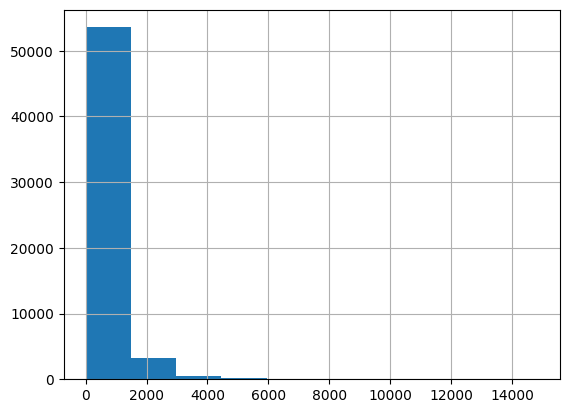

In [77]:
final_df.both_tokens_len.hist()

<Axes: >

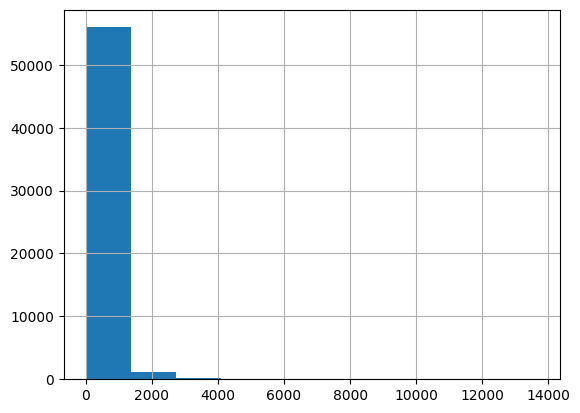

In [36]:
final_df.left_tokens_len.hist()